In [1]:
from __future__ import annotations

import math
import pandas as pd
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score
import matplotlib.pyplot as plt

# My decision Tree Class

In [33]:
class DecisionTree:
    def __init__(self, data: np.ndarray, depth: int, left: DecisionTree, right: DecisionTree, threshold: float,
                 max_depth: int):
        self.left = left
        self.right = right
        self.data = data
        self.depth = depth
        self.threshold = threshold
        self.is_leaf = False
        self.max_depth = max_depth
        self.left_rule = None  # just say which rull goes to left
        self.best_index = -1

    def post_prune(self, alpha):
        left_acc = self.calc_p(self.left.data) * len(self.left.data)
        right_acc = self.right.calc_p(self.right.data) * len(self.right.data)
        imporvment = left_acc + right_acc - self.calc_p(self.data)
        if alpha <= imporvment:
            return False
        else:
            return True  # u must stop

    def predict_data(self, input: np.ndarray, search_max_depth=100, current_depth=1, alpha=0.00):
        if input.ndim == 1:
            if self.is_leaf == True or self.left is None or self.right is None or self.best_index == -1 or search_max_depth <= current_depth or self.post_prune(
                    alpha):
                # it's a leaf node
                # sorry for bad syntax :( no way
                # i want to find must frequent  element in result
                results = self.data[:, -1]
                b = Counter(results.tolist())
                return b.most_common(1)[0][0]

            if input[self.best_index] == self.left_rule:
                # go to left
                return self.left.predict_data(input, current_depth=current_depth + 1 ,alpha=alpha , search_max_depth=search_max_depth)
            else:
                # go to right
                return self.right.predict_data(input, current_depth=current_depth + 1,alpha=alpha , search_max_depth=search_max_depth)
        else:
            m, n = input.shape
            results = []
            for i in range(m):
                res = self.predict_data(input[i, :],alpha=alpha , search_max_depth=search_max_depth)
                results.append(res)
            results = np.array(results)
            return results

    def entropy_calculator(self, p):
        if p == 0 or p == 1:
            return 0
        return - (p * math.log2(p) + (1 - p) * math.log2(1 - p))

    def calc_p(self, data: np.ndarray) -> float:
        # check purity
        # in this part there is no importance for left_rule declaration

        unique, counts = np.unique(data[:, -1], return_counts=True)
        my_dict = dict(zip(unique, counts))
        elements = list(my_dict.keys())

        if len(elements) == 1:
            return 1  # pure

        first_element = my_dict[elements[0]]
        second_element = my_dict[elements[1]]

        p = first_element / (first_element + second_element)

        if p < 0.5:
            p = 1 - p
        return p

    def check_purity(self, data: np.ndarray, purity_threshold: float) -> bool:
        purity = self.calc_p(data)

        if purity > purity_threshold:
            # under threshold
            return True
        else:
            return False

    def split_by_feature(self, data: np.ndarray, column_id: int) -> (
            np.ndarray, np.ndarray, object):
        m, n = data.shape

        unique, counts = np.unique(data[:, column_id], return_counts=True)
        my_dict = dict(zip(unique, counts))
        elements = list(my_dict.keys())

        # we use binary therefor its enough to  check equality with first element
        left_rule = elements[0]

        left = []
        right = []

        for i in range(m):
            if data[i, column_id] == left_rule:
                left.append(data[i, :])
            else:
                right.append(data[i, :])
        left = np.array(left)
        right = np.array(right)

        return left, right, left_rule

    def find_best_column_feature(self):

        if self.check_purity(self.data, self.threshold):
            self.is_leaf = True
            # print(f'finished by purity')
            return

        if self.depth >= self.max_depth:
            self.is_leaf = True
            # print(f'finished by max_depth')
            return

        m, n = self.data.shape
        scores = []

        intial_entropy = self.entropy_calculator(self.calc_p(self.data))

        for i in range(n - 1):
            left, right, _ = self.split_by_feature(self.data, i)

            if left.ndim == 1 or right.ndim == 1:
                scores.append(0)
                continue  # this feature already used

            left_p = self.calc_p(left)
            left_entropy = self.entropy_calculator(p=left_p)

            right_p = self.calc_p(right)
            right_entropy = self.entropy_calculator(p=right_p)

            score = len(left) * left_entropy + len(right) * right_entropy
            score /= len(self.data)  # better to combine both 2 lines
            score = intial_entropy - score

            scores.append(score)

        # print(intial_entropy)
        self.best_index = scores.index(max(scores))
        # print(max(scores))
        # print(self.best_index)

        # I make the best index again , better idea is save it and select it from a list

        left, right, left_rule = self.split_by_feature(self.data, self.best_index)

        if left.ndim != 1:  # i dont know for what but this if statement help the model to run perfectly in depth over 10
            self.left_rule = left_rule
            self.left = DecisionTree(left, self.depth + 1, None, None, self.threshold, self.max_depth)
            self.left.find_best_column_feature()
        if right.ndim != 1:
            self.right = DecisionTree(right, self.depth + 1, None, None, self.threshold, self.max_depth)
            self.right.find_best_column_feature()



# A

In [34]:
data = pd.read_csv("lungcancer.csv")
data = data.to_numpy()

In [35]:
# convert age to binary
m , _ = data.shape
age_threshold = 57
print(m)
for i in range(m):
    if data[i,1] > 57:
        data[i,1] = 1
    else:
        data[i,1] = 0
data

309


array([['M', 1, 1, ..., 2, 2, 'YES'],
       ['M', 1, 2, ..., 2, 2, 'YES'],
       ['F', 1, 1, ..., 1, 2, 'NO'],
       ...,
       ['M', 1, 2, ..., 1, 2, 'YES'],
       ['M', 1, 2, ..., 1, 2, 'YES'],
       ['M', 1, 1, ..., 2, 1, 'YES']], dtype=object)

In [36]:



X_train, X_test, y_train, y_test = train_test_split(data[:, :16], data[:, 15], test_size=0.75, random_state=56)

In [37]:
# train_data_already has the result
tree = DecisionTree(X_train, 0, None, None, 1, 16)
tree.find_best_column_feature()

pred = tree.predict_data(X_test)
acc = accuracy_score(pred, y_test)
pre = precision_score(pred, y_test, pos_label='NO')
print(f'accuracy_score : {acc}, precision_score : {pre}')

accuracy_score : 0.8577586206896551, precision_score : 0.6538461538461539


In [38]:
y_acu = pd.Series(y_test, name='Actual')
y_pred = pd.Series(pred, name='Predicted')
df_confusion = pd.crosstab(y_acu, y_pred)
df_confusion

Predicted,NO,YES
Actual,,
NO,17,9
YES,24,182


# B

In [41]:
scores_acc = []
scores_pre = []
for i in range(7):
    X_train, X_test, y_train, y_test = train_test_split(data[:, :16], data[:, 15], test_size=0.75)
    tree = DecisionTree(X_train, 0, None, None, 1, 16)
    tree.find_best_column_feature()

    pred = tree.predict_data(X_test)
    acc = accuracy_score(pred, y_test)
    pre = precision_score(pred, y_test, pos_label='NO')
    scores_acc.append(acc)
    scores_pre.append(pre)
    # print(f'accuracy_score : {acc}, precision_score : {pre}')
scores_acc = np.array(scores_acc)
scores_pre = np.array(scores_pre)
print(f'avg accuracy : {np.average(scores_acc)}')
print(f'avg precision : {np.average(scores_pre)}')

avg accuracy : 0.8509852216748769
avg precision : 0.5470831303343618


# C

repeat A

In [50]:
train_sizes = [0.2,0.45,0.65,0.85]
for train_size in train_sizes:
    X_train, X_test, y_train, y_test = train_test_split(data[:, :16], data[:, 15], test_size=1 - train_size)
    tree = DecisionTree(X_train, 0, None, None, 1, 16)
    tree.find_best_column_feature()

    pred = tree.predict_data(X_test)
    acc = accuracy_score(pred, y_test)
    pre = precision_score(pred, y_test, pos_label='NO')
    print(f'train_size {train_size} => accuracy_score : {acc}, precision_score : {pre}')

train_size 0.2 => accuracy_score : 0.875, precision_score : 0.28125
train_size 0.45 => accuracy_score : 0.8823529411764706, precision_score : 0.45454545454545453
train_size 0.65 => accuracy_score : 0.8715596330275229, precision_score : 0.38461538461538464
train_size 0.85 => accuracy_score : 0.851063829787234, precision_score : 0.5833333333333334


repeat part B

In [49]:
train_sizes = [0.2,0.45,0.65,0.85]
for train_size in train_sizes:
    scores_acc = []
    scores_pre = []
    for i in range(7):
        X_train, X_test, y_train, y_test = train_test_split(data[:, :16], data[:, 15], test_size=1-train_size)
        tree = DecisionTree(X_train, 0, None, None, 1, 16)
        tree.find_best_column_feature()

        pred = tree.predict_data(X_test)
        acc = accuracy_score(pred, y_test)
        pre = precision_score(pred, y_test, pos_label='NO')
        scores_acc.append(acc)
        scores_pre.append(pre)
        # print(f'accuracy_score : {acc}, precision_score : {pre}')
    scores_acc = np.array(scores_acc)
    scores_pre = np.array(scores_pre)
    print(f'train_size : {train_size} => avg accuracy : {np.average(scores_acc)}, avg precision : {np.average(scores_pre)}')

train_size : 0.2 => avg accuracy : 0.8450460829493088, avg precision : 0.4579966884114349
train_size : 0.45 => avg accuracy : 0.8764705882352943, avg precision : 0.467243119199641
train_size : 0.65 => avg accuracy : 0.8794233289646133, avg precision : 0.5303571428571429
train_size : 0.85 => avg accuracy : 0.8996960486322187, avg precision : 0.6409297052154195


# D

In [54]:
X_train, X_test, y_train, y_test = train_test_split(data[:, :16], data[:, 15], test_size=0.25)
scores_acc = []
scores_pre = []
index = []
for max_depth in range(1 , 15):
    index.append(max_depth)
    tree = DecisionTree(X_train, 0, None, None, 1, 16)
    tree.find_best_column_feature()
    pred = tree.predict_data(X_test ,alpha=0.1 , search_max_depth=max_depth)
    acc = accuracy_score(pred, y_test)
    pre = precision_score(pred, y_test, pos_label='NO')
    scores_acc.append(acc)
    scores_pre.append(pre)

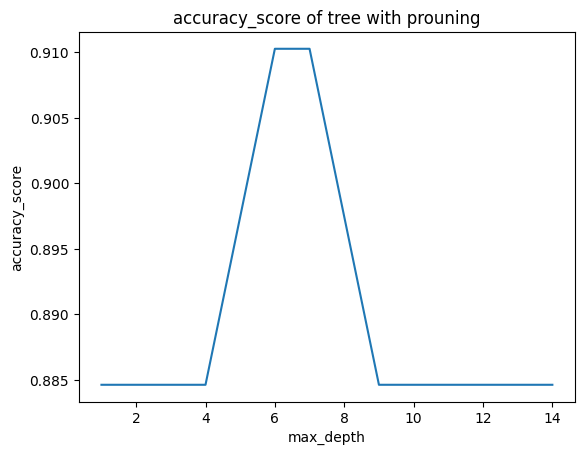

In [55]:
plt.title("accuracy_score of tree with prouning")
plt.ylabel("accuracy_score")
plt.xlabel("max_depth")
plt.plot(index,scores_acc)

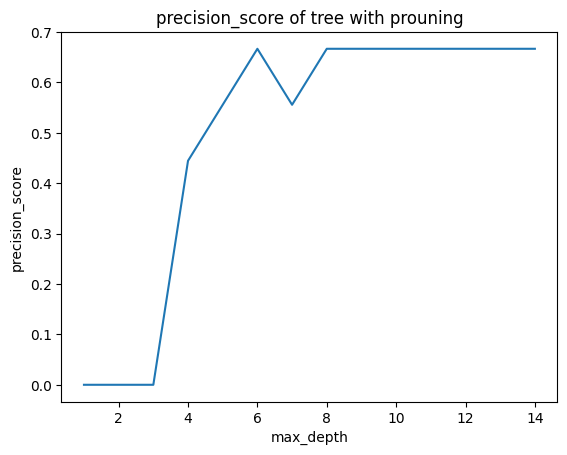

In [56]:
plt.title("precision_score of tree with prouning")
plt.ylabel("precision_score")
plt.xlabel("max_depth")
plt.plot(index,scores_pre)